![](/images/blog/poisson-rate-estimation-variance.png)

Many applications of statistics to genomics involve modelling read counts from [high-throughput sequencing experiments](https://en.wikipedia.org/wiki/DNA_sequencing#High-throughput_methods) as originating from a [Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process#Interpreted_as_a_counting_process) (or as something similar based on the closely-related [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution)). In these experiments, we often want to estimate the true concentration $\mu$ of a particular DNA or RNA sequence in a sequencing library. This corresponds to the "rate" parameter of a Poison process, while the total number of reads sequenced can be thought of as related to its "elapsed time". How does the sequencing depth of the dataset (the total number of reads) impact the variance in the estimate of the true concentration? Read on to find out!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Zc84Ohe9LCh3jpJd9OJBjIB9lKLt5Lbq)

<!-- TEASER_END -->

In [0]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from tqdm import tnrange

Let's say we have some RNA in a cell present at a true concentration $\mu$.

In [0]:
true_conc = 3.4

We will estimate this true concentration by sequencing $n$ reads in a Poisson process $X \sim \textrm{Poisson}(\mu n)$, and then dividing the number of reads that map to that RNA $X$ by the total number of reads sequenced $n$ to obtain an estimate of the concentration.

Mathematically, we can write our estimate of the true concentration as

$$\hat{\mu} = X / n; \quad X \sim \textrm{Poisson}(\mu n)$$

In [0]:
def estimate_conc(reads):
    read_count = stats.poisson(true_conc * reads).rvs()
    return read_count / float(reads)

Each call of the function represents one sequencing experiment in which we sequence a certain number of reads once and obtain one estimate of the true concentration.

In [0]:
estimate_conc(10)

3.0

We can do this 1000 times for each of 5 logarithmically spaced read depths.

In [0]:
df = pd.DataFrame([{'reads': n, 'est_conc': estimate_conc(n)}
                   for _ in tnrange(1000)
                   for n in [10, 100, 1000, 10000, 100000]])

We can then plot the mean estimate $\textrm{E}(\hat{\mu})$ (solid blue line) and its 95% confidence intervals (blue shaded area, should be related to the sampling variance of $\hat{\mu}$) as a function of the number of reads $n$. For reference we plot the true concentration $\mu$ as a dashed gray line.

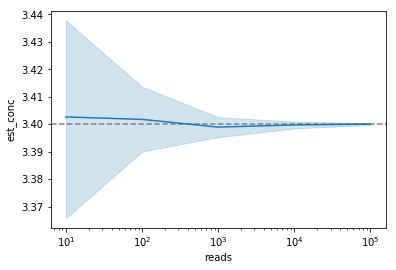

In [0]:
sns.lineplot(x='reads', y='est_conc', data=df)
plt.xscale('log')
xmin, xmax = plt.xlim()
plt.hlines(true_conc, xmin, xmax, color='gray', linestyle='--')
plt.xlim(xmin, xmax);

It's clear that the more reads we have the lower the sampling variance of $\hat{\mu}$ gets.

Theoretically, from

$$X \sim \textrm{Poisson}(\mu n)$$

we have

$$\textrm{Var}(X) = \mu n$$

and then from

$$\hat{\mu} = X / n$$

we have

\begin{align}
\textrm{Var}(\hat{\mu}) &= \textrm{Var}(X / n) \\
&= \frac{1}{n^2}\textrm{Var}(X) \\
&= \frac{\mu n}{n^2} \\
&= \frac{\mu}{n}
\end{align}

We can confirm this by computing the $\textrm{Var}(\hat{\mu})$ we empirically observe in our simulations (solid blue line) and overlaying the theoretically expected relationship between number of reads and $\textrm{Var}(\hat{\mu})$ (dashed gray line).

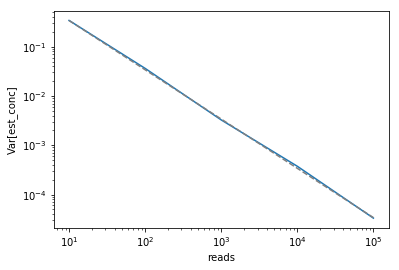

In [0]:
var_df = df.groupby('reads').var().rename(columns={'est_conc': 'var'})
plt.plot(var_df.index, var_df['var'])
plt.plot(var_df.index, true_conc / var_df.index.astype(float), color='gray',
         linestyle='--')
plt.xlabel('reads')
plt.ylabel('Var[est_conc]')
plt.xscale('log')
plt.yscale('log');